In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
import re
from scipy.spatial.distance import jaccard
from sklearn.cluster import SpectralClustering as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial import distance
from networkx.algorithms.community import k_clique_communities,girvan_newman
import itertools
import datetime

In [5]:
def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

def getThread(num,data):
    thread = data[data["ThreadID"]== threads[num]]
    members = thread["MemberID"].unique()
    thread = thread.reset_index(drop = True)
    
    for i in range(0,len(thread)):
        thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    
    #encode member names
    index = 0
    for i in range(0,len(members)):
        thread["MemberID"][thread["MemberID"] == members[i]] = index
        index += 1

    thread = thread.sort_values(by = ["P_Date",'MessageID'])
    
    return thread

### Load Data

In [2]:
data = pd.read_csv("../GawaherSentiment.csv")
threads = data["ThreadID"].unique()


### Thread over time

In [3]:
def makeGraph(thread):
    members = thread["MemberID"].unique()
    memberComments = []
    memberSentiments = []

    for i in members:
        memberComments.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(thread[thread["MemberID"] == i]["AllenNLP"].iloc[-1])

    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))

    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)

    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    centrality = nx.information_centrality(G)
    
    return G, nodeDict, edgeDict, centrality

C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.

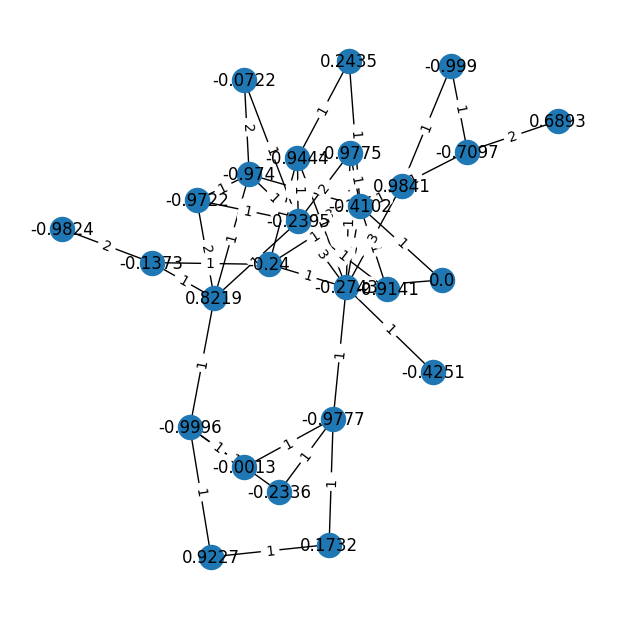

In [6]:
plt.figure(figsize = (6,6))
thread = getThread(0,data)
G, nodeDict, edgeDict, centrality = makeGraph(thread)

pos=nx.kamada_kawai_layout(G)
nx.draw(G, pos = pos, labels = nodeDict,  cmap='RdYlGn')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeDict);

### Feature Creation

deltaSentiments = []
connectionSentiments = []
connectionCentrality = []
meanSentiment = []
messageLength = []
threadLength = []
edgeDegree = []
posterNumber = []
threadID = []


for i in range(0,len(threads)):
    thread = getThread(i,data)
   
    for i in range(0,len(thread)-1):
        G, nodeDict, edgeDict, centrality = makeGraph(thread.iloc[:i+1])
        
        deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i+1]))
        #deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        threadLength.append(i+1)
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
        threadID.append(thread["ThreadID"].iloc[i])



features = pd.DataFrame(np.array([threadID,threadLength,posterNumber,connectionCentrality, messageLength,
                                  connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                       columns = ["threadID","threadLength","posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])

features.replace([np.inf, -np.inf], 1, inplace=True)
features.dropna(inplace=True)


In [7]:
features = pd.read_csv("features.csv", index_col =0)
features

,threadID,threadLength,posterNumber,centrality,messageLength,sentiment,degree,meanSentiment,deltaSentiments
1,240.0,2.0,0.0,1.000000,23908.0,0.142836,0.0,-0.183807,-0.020485
2,240.0,3.0,0.0,1.000000,3968.0,0.181680,0.0,-0.020485,0.046903
3,240.0,4.0,0.0,1.000000,3469.0,0.370321,0.0,0.046903,0.127758
4,240.0,5.0,0.0,1.000000,97.0,-0.005715,0.0,0.127758,0.101063
5,240.0,6.0,7.0,1.000000,380.0,0.198179,1.0,0.101063,0.117249
...,...,...,...,...,...,...,...,...,...
134777,512704.0,35.0,3.0,0.176471,150.0,-0.988900,2.0,-0.370811,-0.388471
134778,512704.0,36.0,6.0,0.085714,173.0,-0.332775,1.0,-0.388471,-0.386924
134779,512704.0,37.0,3.0,0.150000,337.0,0.179732,3.0,-0.386924,-0.371609
134780,512704.0,38.0,6.0,0.085714,415.0,-0.990433,1.0,-0.371609,-0.387894


threads = features["threadID"].unique()

negative = []
positive = []

for i in threads:
    if np.mean(features[features["threadID"] ==i]["meanSentiment"]) >=0:
        positive.append(i)
    else:
        negative.append(i)

#### Balance features

balanceThreads = np.random.choice(negative, size = len(positive))

negFeatures = features[features["threadID"].isin(balanceThreads)]
posFeatures = features[features["threadID"].isin(positive)]

features = pd.concat([negFeatures,posFeatures])

### Model

In [8]:
import tensorflow as tf
from keras.layers import Dense,LSTM,Embedding, InputLayer, BatchNormalization,Dropout
from keras.models import Sequential,Model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [9]:
mask = []

for i in threads:

    thread = features[features["threadID"] == i]
    mask.append(thread["threadLength"] < int(.8*len(thread)))
mask = np.concatenate(mask)

In [10]:
xTrain = features[features.columns[1:-1]][mask]
yTrain = features[features.columns[-1]][mask]
xTest = features[features.columns[1:-1]][~mask]
yTest = features[features.columns[-1]][~mask]

"""
xScaler = StandardScaler().fit(xTrain)
yScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))

xTrain = xScaler.transform(xTrain)
yTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))

xTest = xScaler.transform(xTest)
yTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))


"""



'\nxScaler = StandardScaler().fit(xTrain)\nyScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))\n\nxTrain = xScaler.transform(xTrain)\nyTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))\n\nxTest = xScaler.transform(xTest)\nyTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))\n\n\n'

In [11]:
xTrain = xTrain.to_numpy().reshape(-1,1,7)
xTest = xTest.to_numpy().reshape(-1,1,7)

In [12]:
batch = 32
epoch = 10
act = 'tanh'

model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128, activation=act, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(128, activation=act, return_sequences=False))
model.add(Dropout(.2))
model.add(Dense(100,activation=act))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics = ['mape'])
model.fit(xTrain, yTrain, batch_size= batch, epochs=epoch, verbose=1)



Epoch 1/10
3173/3173 [==============================] - 16s 4ms/step - loss: 0.0070 - mape: 5423.0874
Epoch 2/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0060 - mape: 5437.8208
Epoch 3/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0057 - mape: 3593.1250
Epoch 4/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0056 - mape: 4916.2612
Epoch 5/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.0054 - mape: 6409.9399
Epoch 6/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0054 - mape: 4105.5767
Epoch 7/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0053 - mape: 4181.7671
Epoch 8/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.0053 - mape: 6504.2861
Epoch 9/10
3173/3173 [==============================] - 13s 4ms/step - loss: 0.0053 - mape: 7621.0259
Epoch 10/10
3173/3173 [==============================] - 12s 4ms/step - loss: 0.00

### Analysis

In [13]:
def featureExtract(i):
    deltaSentiments = []
    connectionSentiments = []
    connectionCentrality = []
    meanSentiment = []
    messageLength = []
    threadLength = []
    edgeDegree = []
    posterNumber = []
    threadID = []


    thread = getThread(i,data)

    for i in range(0,len(thread)-1):
        G, nodeDict, edgeDict, centrality = makeGraph(thread.iloc[:i+1])

        deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i+1]))
        #deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        threadLength.append(i+1)
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
        threadID.append(thread["ThreadID"].iloc[i])

    features = pd.DataFrame(np.array([threadID,threadLength,posterNumber,connectionCentrality, messageLength,
                                  connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                       columns = ["threadID","threadLength","posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])
    
    features.replace([np.inf, -np.inf], 1, inplace=True)
    features.dropna(inplace=True)

    return features

In [14]:
yPred = model.predict(xTest).reshape(-1,1)


978/978 [==============================] - 2s 1ms/step


In [15]:
r2_score(yTest,yPred)

0.9957554824038591

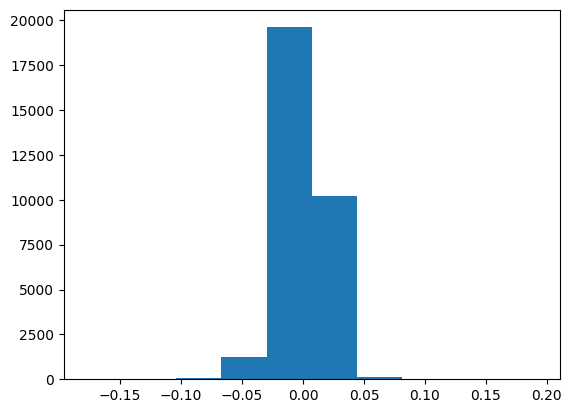

In [16]:
plt.hist(yTest.to_numpy().reshape(-1,1) - yPred);


In [18]:
test = featureExtract(-1)

C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

In [19]:
predTest = test[test.columns[1:-1]]

In [20]:
preds = model.predict(predTest.to_numpy().reshape(-1,1,7))

2/2 [==============================] - 0s 3ms/step


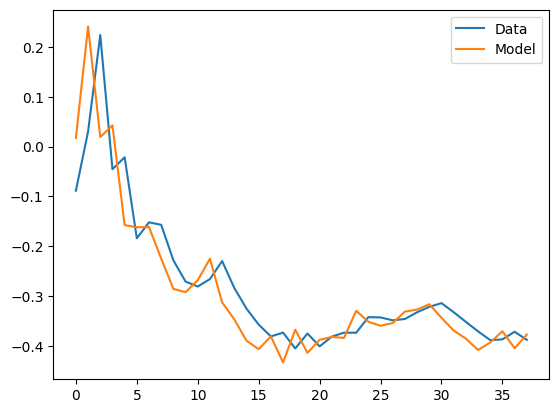

In [21]:
t = np.arange(0,len(test))
plt.plot(t,test["meanSentiment"], label = "Data")
plt.plot(t,preds.reshape(1,-1)[0], label = "Model")
plt.legend()

### Forecasting

In [144]:
def getBootStrap(predTest, testSample):

    bootStrap = pd.DataFrame(testSample.iloc[-10:]).sample(n =  len(predTest)-len(testSample),replace=True)
    bootStrap.reset_index(drop = True,inplace = True)
    bootStrap["threadLength"] = np.arange(len(testSample), len(bootStrap)+len(testSample))

    pred = model.predict(testSample.iloc[-1].to_numpy().reshape(-1,1,7), verbose = False)
    bootStrap.iloc[0]["meanSentiment"] = pred

    for i in range(0,len(bootStrap)-1):
        pred = model.predict(bootStrap.iloc[i].to_numpy().reshape(-1,1,7), verbose = False)
        bootStrap.iloc[i+1]["meanSentiment"] = pred

    return  bootStrap["meanSentiment"]

C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12272\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

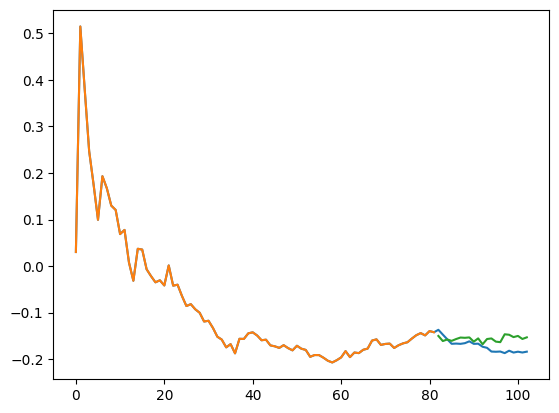

In [147]:
test = featureExtract(-10)
predTest = test[test.columns[1:-1]]
testSample = predTest.iloc[0:int(.8*len(predTest))]

samples = []
for i in range(0,10):
    samples.append(getBootStrap(predTest, testSample))
    
forecast= np.mean(samples,axis = 0)

t = np.arange(0,len(testSample))
forecastT = np.arange(len(testSample), len(forecast) +len(testSample))

plt.plot(predTest["threadLength"] -2, predTest["meanSentiment"])
plt.plot(t,testSample["meanSentiment"])
plt.plot(forecastT, forecast)

In [ ]:
error = []
for i in range(len(error),len(threads)):
    test = featureExtract(i)
    predTest = test[test.columns[1:-1]]
    testSample = predTest.iloc[0:int(.8*len(predTest))]

    samples = []

    for i in range(0,10):

        samples.append(getBootStrap(predTest, testSample))

    forecast = np.mean(samples, axis = 0)
    error.append(mean_squared_error(predTest["meanSentiment"].iloc[len(testSample):],forecast))

C:\Users\Le\AppData\Local\Temp\ipykernel_21440\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_21440\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

In [1]:
print(np.mean(error))

plt.hist(error)

NameError: name 'np' is not defined